# Coursework 3: Part A - RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook containing your answers. Write your answers in the cells below each question.


#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 5th March, 2020**

## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding (70%)
In this part you will have to:

#### Part 1.1 (20%)

Implement the LSTM RNN cell.

#### Part 1.2 (30%)

- Modify the RNNModel class, such that it is a Bidirectional RNN.
- Compare vanilla RNN, GRU, LSTM, and bidirectional VS unidirectional RNNs and report their performance with respect to accuracy and time cost.

#### Part 1.3 (20%)

Then for your best model you will perform some improvements:
- In terms of architecture optimisation (number of layers, hidden state dimension)
- Better utilisation of the hidden state sequence output by the RNN, for classification.
- Report the improvements you achieved, as well as an explanation for why they worked.

### Part 2 - Theory (30%)

Here you will answer some theoretical questions about RNN training, and CTC -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the tutorial part: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

In [1]:
import os
data_dir = './data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

! wget https://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
! unzip data_speech_commands_v0.02.zip -d ./data/data_speech_commands_v0.02



Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_speech_commands_v0.02/three/b76f6088_nohash_2.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b76f6088_nohash_3.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b7a0754f_nohash_0.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b7a0754f_nohash_1.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b7a0754f_nohash_2.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b7a0754f_nohash_3.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b7a6f709_nohash_0.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b7a6f709_nohash_1.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b7e9f841_nohash_0.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b80d6c5e_nohash_0.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b80d6c5e_nohash_1.wav  
  inflating: ./data/data_speech_commands_v0.02/three/b83c1acf_nohash_0.wav  
  inflating: ./data/data_

Set-up code and imports

In [0]:
import math

from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Data provider class definition.

Here you can give different configuration to the [mfcc function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html). Additional keyword arguments are defined in the [melspectrogram function](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram).

One may additionally consider standardising the samples (remove mean, divide by std) or performing data augmentation, e.g., by adding low variance white or noise.

In [0]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "/data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "/data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        ########################################################################
        ## YOU MAY CONFIGURE HERE.
        ########################################################################
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)
        ########################################################################
        ## DO NOT CONFIGURE BEYOND HERE.
        ########################################################################
        
        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "/data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

Load Dataset - you may vary batch size.

In [0]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "./data" # this should change depending on where you have stored the data files

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

## YOU MAY CHANGE THE BATCH SIZE.
batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Part 1.1 (20%)

Finalise the LSTM cell (you can base your code on that of the GRU cell).

You are allowed to use nn.Linear.

In [0]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # self.linear_ix = nn.Linear(self.input_size, self.hidden_size, self.bias)
        # self.linear_ih = nn.Linear(self.hidden_size, self.hidden_size, self.bias)
        # self.linear_fx = nn.Linear(self.input_size, self.hidden_size, self.bias)
        # self.linear_fh = nn.Linear(self.hidden_size, self.hidden_size, self.bias)
        # self.linear_gx = nn.Linear(self.input_size, self.hidden_size, self.bias)
        # self.linear_gh = nn.Linear(self.hidden_size, self.hidden_size, self.bias)
        # self.linear_ox = nn.Linear(self.input_size, self.hidden_size, self.bias)
        # self.linear_oh = nn.Linear(self.hidden_size, self.hidden_size, self.bias)
        self.linear_x = nn.Linear(self.input_size, 4*self.hidden_size, self.bias)
        self.linear_h = nn.Linear(self.hidden_size, 4*self.hidden_size, self.bias)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        if not isinstance(hx, tuple) or len(hx) != 2:
            raise ValueError("hx should be a tuple contain ht and ct. (ht,ct)")
        else:
            # it = self.sigmoid(self.linear_ix(input)+self.linear_ih(hx[0]))
            # ft = self.sigmoid(self.linear_fx(input)+self.linear_fh(hx[0]))
            # gt = self.tanh(self.linear_gx(input)+self.linear_gh(hx[0]))
            # ot = self.sigmoid(self.linear_ox(input)+self.linear_oh(hx[0]))
            gate_x = self.linear_x(input)
            gate_h = self.linear_h(hx[0])
            x_i, x_f, x_g, x_o = gate_x.chunk(4,1)
            h_i, h_f, h_g, h_o = gate_h.chunk(4,1)
            it = self.sigmoid(x_i+h_i)
            ft = self.sigmoid(x_f+h_f)
            gt = self.tanh(x_g+h_g)
            ot = self.sigmoid(x_o+h_o)
            cy = ft*hx[1]+it*gt
            hy = ot*self.tanh(cy)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        hy = self.x2h(input)+self.h2h(hx)
        if self.nonlinearity == "tanh":
            hy = torch.tanh(hy)
        else:
            hy = torch.relu(hy)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
            
        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # self.linear_rx = nn.Linear(self.input_size, self.hidden_size, self.bias)
        # self.linear_rh = nn.Linear(self.hidden_size, self.hidden_size, self.bias)
        # self.linear_zx = nn.Linear(self.input_size, self.hidden_size, self.bias)
        # self.linear_zh = nn.Linear(self.hidden_size, self.hidden_size, self.bias)
        # self.linear_nx = nn.Linear(self.input_size, self.hidden_size, self.bias)
        # self.linear_nh = nn.Linear(self.hidden_size, self.hidden_size, self.bias)
        self.linear_x = nn.Linear(self.input_size, 3*self.hidden_size, self.bias)
        self.linear_h = nn.Linear(self.hidden_size, 3*self.hidden_size, self.bias)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        # rt = self.sigmoid(self.linear_rx(input)+self.linear_rh(hx))
        # zt = self.sigmoid(self.linear_zx(input)+self.linear_zh(hx))
        # nt = self.tanh(self.linear_nx(input)+rt*self.linear_nh(hx))
        # hy = (1-zt)*nt+zt*hx
        

        gate_x = self.linear_x(input)
        gate_h = self.linear_h(hx)
        x_r, x_z, x_n = gate_x.chunk(3,1)
        # x_z = gate_x[:, self.hidden_size:2*self.hidden_size]
        # x_n = gate_x[:, -self.hidden_size:]
        h_r, h_z, h_n = gate_h.chunk(3,1)
        # h_z = gate_h[:, self.hidden_size:2*self.hidden_size]
        # h_n = gate_h[:, -self.hidden_size:]
        rt = self.sigmoid(x_r+h_r)
        zt = self.sigmoid(x_z+h_z)
        nt = self.tanh(x_n+rt*h_n)
        hy = (1-zt)*nt+zt*hx
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

In [0]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                               self.hidden_size,
                                               self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size, requires_grad=True).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size, requires_grad=True))
        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        count = 0
        h_list = []
        if self.mode == 'LSTM':
            for h in h0:
                if hx is None:
                    h_list.append((h, h))
                else:
                    h_list.append(h)
            for seq in range(input.size(1)):
                for idx, layer in enumerate(self.rnn_cell_list):
                    if idx == 0:
                        hy = layer(input[:,seq,:], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                    else:
                        hy = layer(hy[0], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                outs.append(hy[0])
                count += 1
        else:
            for h in h0:
                h_list.append(h)
            for seq in range(input.size(1)):
                for idx, layer in enumerate(self.rnn_cell_list):
                    if idx == 0:
                        hy = layer(input[:,seq,:], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                    else:
                        hy = layer(hy, h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                outs.append(hy)
                count += 1
        '''
        if self.mode == 'LSTM': 
            if h0 is None:
                h0 = (h0, h0)
            for seq in range(input.size(1)):
                for idx, layer in enumerate(self.rnn_cell_list):
                    if idx == 0:
                        hy = layer(input[:,seq,:], h0[idx])
                        h0[idx].data = hy.data
                    else:
                        hy = layer(hy, h0[idx])
                        h0[idx].data = hy.data
                outs.append(hy[0])
        else:
            for seq in range(input.size(1)):
                hy_list = []
                for idx, layer in enumerate(self.rnn_cell_list):
                    if idx == 0:
                        hy = layer(input[:,seq,:], h0[idx])
                        h0[idx].data = hy.data
                    else:
                        hy = layer(hy, h0[idx])
                        h0[idx].data = hy.data
                outs.append(hy)
        '''
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        out = outs[-1].squeeze() # Related to Part 1.3.

        out = self.fc(out)
        
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_rev_cell_list = nn.ModuleList()

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        if mode == 'LSTM':
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                               self.hidden_size,
                                               self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")

        if mode == 'LSTM':
            self.rnn_rev_cell_list.append(LSTMCell(self.input_size,
                                               self.hidden_size,
                                               self.bias))
            for l in range(1, self.num_layers):
                self.rnn_rev_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))

        elif mode == 'GRU':
            self.rnn_rev_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_rev_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_rev_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_rev_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_rev_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(2*self.hidden_size, 1)
        self.fc = nn.Linear(2*self.hidden_size, self.output_size)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        if torch.cuda.is_available():
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
            
        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        
        count = 0
        h_list = []
        h_relist = []
        if self.mode == 'LSTM':
            for h in h0:
                if hx is None:
                    h_list.append((h, h))
                    h_relist.append((h,h))
                else:
                    h_list.append(h)
                    h_relist.append(h)
            for seq in range(input.size(1)):
                for idx, i in enumerate(range(self.num_layers)):
                    if idx == 0:
                        hy = self.rnn_cell_list[i](input[:,seq,:], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                        hy_re = self.rnn_rev_cell_list[i](input[:, -seq-1, :], h_relist[count*self.num_layers+idx])
                        h_relist.append(hy_re)
                    else:
                        hy = self.rnn_cell_list[i](hy[0], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                        hy_re = self.rnn_rev_cell_list[i](hy_re[0],  h_relist[count*self.num_layers+idx])
                        h_relist.append(hy_re)
                outs.append(hy[0])
                outs_rev.append(hy_re[0])
                count += 1
        else:
            for h in h0:
                h_list.append(h)
                h_relist.append(h)
            for seq in range(input.size(1)):
                for idx, i in enumerate(range(self.num_layers)):
                    if idx == 0:
                        hy = self.rnn_cell_list[i](input[:,seq,:], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                        hy_re = self.rnn_rev_cell_list[i](input[:, -seq-1, :], h_relist[count*self.num_layers+idx])
                        h_relist.append(hy_re)
                    else:
                        hy = self.rnn_cell_list[i](hy, h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                        hy_re = self.rnn_rev_cell_list[i](hy_re,  h_relist[count*self.num_layers+idx])
                        h_relist.append(hy_re)
                outs.append(hy)
                outs_rev.append(hy_re)
                count += 1
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()  # Related to question 10.
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)

        out = self.fc(out)
        return out

## Part 1.2 (30%)

In the following, experiment with different RNN architectures (RNN cell types, number of layers, hidden state dimensionality, MFCC configuration, unidirectional VS bidirectional) and report the accuracy (pay also attention to the training and validation cost), as well as training time. 

* What are your justifications for these results?

* On the notebook, leave the execution of your best model.

In [9]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch
from time import time


seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 2
bias = True

#model = RNNModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0

start = time()
for epoch in tqdm_notebook(range(num_epochs)):
    train_loss = []
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        train_loss.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                
                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Train_Loss: {}  Val_Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, torch.mean(torch.Tensor(train_loss)), loss.item(), v_accuracy, reported_t_accuracy))

end = time()
print('Training time '+str(-start+end))

Iteration: 20. Train_Loss: 1.088720679283142  Val_Loss: 1.0965015888214111. V-Accuracy: 40  T-Accuracy: 40
Iteration: 40. Train_Loss: 1.0754643678665161  Val_Loss: 1.0234771966934204. V-Accuracy: 49  T-Accuracy: 49
Iteration: 60. Train_Loss: 1.0500832796096802  Val_Loss: 0.9650886654853821. V-Accuracy: 60  T-Accuracy: 58
Iteration: 80. Train_Loss: 1.008131980895996  Val_Loss: 0.8276638984680176. V-Accuracy: 64  T-Accuracy: 63
Iteration: 100. Train_Loss: 0.7279646992683411  Val_Loss: 0.7283003330230713. V-Accuracy: 69  T-Accuracy: 66
Iteration: 120. Train_Loss: 0.7291191220283508  Val_Loss: 0.7242491841316223. V-Accuracy: 73  T-Accuracy: 71
Iteration: 140. Train_Loss: 0.7005767822265625  Val_Loss: 0.5854682326316833. V-Accuracy: 77  T-Accuracy: 75
Iteration: 160. Train_Loss: 0.6718082427978516  Val_Loss: 0.5926697254180908. V-Accuracy: 80  T-Accuracy: 78
Iteration: 180. Train_Loss: 0.6385062336921692  Val_Loss: 0.5050485134124756. V-Accuracy: 81  T-Accuracy: 80
Iteration: 200. Train_Los

### Hyper-parameter search

In [16]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch
from time import time


seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dims = [16, 32, 64,128]
layer_dims = [1, 2, 3, 4, 5]
biass = [True, False]
modes = ['GRU', 'LSTM', 'RNN_TANH', 'RNN_RELU']
bis = [True, False]

#model = RNNModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim)


## YOU MAY CONFIGURE THESE.
learning_rates = [0.01, 0.001, 0.00005]

for hidden_dim in hidden_dims:
    for layer_dim in layer_dims:
        for bias in biass:
            for mode in modes:
                for learning_rate in learning_rates:
                    for bi in bis:
                        if bi:
                            model = BidirRecurrentModel(mode, input_dim, hidden_dim, layer_dim, bias, output_dim)
                        else:
                            model = RNNModel(mode, input_dim, hidden_dim, layer_dim, bias, output_dim)

                        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                        if torch.cuda.is_available():
                            model.cuda()
                            
                        criterion = nn.CrossEntropyLoss()
                        print('Bidirection: '+str(bi))
                        print('RNN type: '+mode)
                        print('Learning rate: '+str(learning_rate))
                        print('Bias: '+str(bias))
                        print('Number of layer: '+str(layer_dim))
                        print('Number of hidden dimension: '+str(hidden_dim))
                        loss_list = []
                        iter = 0
                        max_v_accuracy = 0
                        reported_t_accuracy = 0
                        max_t_accuracy = 0
                        start = time()
                        for epoch in range(num_epochs):
                            train_loss = []
                            for i, (audio, labels) in enumerate(train_loader):
                                if torch.cuda.is_available():
                                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                                    labels = Variable(labels.cuda())
                                else:
                                    audio = Variable(audio.view(-1, seq_dim, input_dim))
                                    labels = Variable(labels)

                                optimizer.zero_grad()

                                outputs = model(audio)

                                loss = criterion(outputs, labels)

                                if torch.cuda.is_available():
                                    loss.cuda()

                                loss.backward()

                                optimizer.step()

                                loss_list.append(loss.item())
                                train_loss.append(loss.item())
                                iter += 1

                               
                        correct = 0
                        total = 0
                        for audio, labels in valid_loader:
                            if torch.cuda.is_available():
                                audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                                labels = Variable(labels.cuda())
                            else:
                                audio = Variable(audio.view(-1, seq_dim, input_dim))
                            
                            outputs = model(audio)
                            loss_val = criterion(outputs, labels)
                            _, predicted = torch.max(outputs.data, 1)

                            total += labels.size(0)

                            if torch.cuda.is_available():
                                correct += (predicted.cpu() == labels.cpu()).sum()
                            else:
                                correct += (predicted == labels).sum()

                        v_accuracy = 100 * correct / total
                        
                        is_best = False
                        if v_accuracy >= max_v_accuracy:
                            max_v_accuracy = v_accuracy
                            is_best = True

                        if is_best:
                            for audio, labels in test_loader:
                                if torch.cuda.is_available():
                                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                                else:
                                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                                outputs = model(audio)

                                _, predicted = torch.max(outputs.data, 1)

                                total += labels.size(0)

                                if torch.cuda.is_available():
                                    correct += (predicted.cpu() == labels.cpu()).sum()
                                else:
                                    correct += (predicted == labels).sum()

                            t_accuracy = 100 * correct / total
                            reported_t_accuracy = t_accuracy

                        print(' Val_Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(loss_val.item(), v_accuracy, reported_t_accuracy))

                        end = time()
                        hours, rem = divmod(end-start, 3600)
                        minutes, seconds = divmod(rem, 60)
                        print("Train time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
                        print('----------------------------------------------------------')

Bidirection: True
RNN type: GRU
Learning rate: 0.01
Bias: True
Number of layer: 1
Number of hidden dimension: 16
 Val_Loss: 0.6012589931488037. V-Accuracy: 71  T-Accuracy: 71
Train time: 00:06:15.18
----------------------------------------------------------
Bidirection: False
RNN type: GRU
Learning rate: 0.01
Bias: True
Number of layer: 1
Number of hidden dimension: 16


KeyboardInterrupt: ignored

## Part 1.3 (20%)

RNN hidden state. In the code above in the RNNModel and BidirRecurrentModel, we utilise the final hidden state extracted by the model in order to make the final pass through a feed-forward layer towards a final prediction.

a) Can you think of reasons this might not be the best choice? Please write down two variations that could possibly yield better result.

b) Experiment with such alternative approaches in the code below in order to achieve a better result and report it below.

* Your answer here.\
In the above model, we only used the last state of the sequence to the feed forward network. Although the output of the previous state was used in the next state, we didn't used all the state's output in the feed forward network and these information was lost. This problem can led to a no good result. 

Possiable solution:
1. We can calculate the average of output in the sequence and use the average in the fully connected network.
2. We take the maximum of all the output of the sequence as the input of the fully connected network.
3. We take all the output as a long vector which dimension is num_hidden_dim $\times$ num_sequence and then take this vector as the input of the fully connected network

In [0]:
class RNNModel_part3(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size, method):
        super(RNNModel_part3, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        self.method = method
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                               self.hidden_size,
                                               self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        if self.method == 'fully':
            self.fc = nn.Linear(self.hidden_size*32, self.output_size)

        else:    
            self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):
        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size, requires_grad=True).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size, requires_grad=True))
        else:
             h0 = hx

        outs = []

        ########################################################################
        ## START OF YOUR CODE
        ########################################################################

        count = 0
        h_list = []
        if self.mode == 'LSTM':
            for h in h0:
                if hx is None:
                    h_list.append((h, h))
                else:
                    h_list.append(h)
            for seq in range(input.size(1)):
                for idx, layer in enumerate(self.rnn_cell_list):
                    if idx == 0:
                        hy = layer(input[:,seq,:], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                    else:
                        hy = layer(hy[0], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                outs.append(hy[0])
                count += 1
        else:
            for h in h0:
                h_list.append(h)
            for seq in range(input.size(1)):
                for idx, layer in enumerate(self.rnn_cell_list):
                    if idx == 0:
                        hy = layer(input[:,seq,:], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                    else:
                        hy = layer(hy, h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                outs.append(hy)
                count += 1
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        if self.method == 'default':
            out = outs[-1].squeeze() # Related to Part 1.3.
        elif self.method == 'average':
            outs = torch.cat([out.unsqueeze(dim = 0) for out in outs])
            out = torch.mean(outs, dim = 0)

        elif self.method == 'max':
            outs = torch.cat([out.unsqueeze(dim = 0) for out in outs])
            out,_ = torch.max(outs, dim = 0)

        elif self.method == 'fully':
            outs = torch.cat([out.unsqueeze(dim = 0) for out in outs])
            outs = torch.transpose(outs, 0, 1)
            out = outs.reshape(outs.shape[0], -1)

        out = self.fc(out)
        
        
        return out
    

class BidirRecurrentModel_part3(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size, method):
        super(BidirRecurrentModel_part3, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_rev_cell_list = nn.ModuleList()
        self.method = method
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        if mode == 'LSTM':
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                               self.hidden_size,
                                               self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")

        if mode == 'LSTM':
            self.rnn_rev_cell_list.append(LSTMCell(self.input_size,
                                               self.hidden_size,
                                               self.bias))
            for l in range(1, self.num_layers):
                self.rnn_rev_cell_list.append(LSTMCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias))

        elif mode == 'GRU':
            self.rnn_rev_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_rev_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_rev_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_rev_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_rev_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_rev_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(2*self.hidden_size, 1)
        if self.method == 'fully':
            self.fc = nn.Linear(2*self.hidden_size*32, self.output_size)

        else:    
            self.fc = nn.Linear(2*self.hidden_size, self.output_size)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
        if torch.cuda.is_available():
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
        else:
            hT = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
            
            
        outs = []
        outs_rev = []
        
        ########################################################################
        ## START OF YOUR CODE
        ########################################################################
        count = 0
        h_list = []
        h_relist = []
        if self.mode == 'LSTM':
            for h in h0:
                if hx is None:
                    h_list.append((h, h))
                    h_relist.append((h,h))
                else:
                    h_list.append(h)
                    h_relist.append(h)
            for seq in range(input.size(1)):
                for idx, i in enumerate(range(self.num_layers)):
                    if idx == 0:
                        hy = self.rnn_cell_list[i](input[:,seq,:], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                        hy_re = self.rnn_rev_cell_list[i](input[:, -seq-1, :], h_relist[count*self.num_layers+idx])
                        h_relist.append(hy_re)
                    else:
                        hy = self.rnn_cell_list[i](hy[0], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                        hy_re = self.rnn_rev_cell_list[i](hy_re[0],  h_relist[count*self.num_layers+idx])
                        h_relist.append(hy_re)
                outs.append(hy[0])
                outs_rev.append(hy_re[0])
                count += 1
        else:
            for h in h0:
                h_list.append(h)
                h_relist.append(h)
            for seq in range(input.size(1)):
                for idx, i in enumerate(range(self.num_layers)):
                    if idx == 0:
                        hy = self.rnn_cell_list[i](input[:,seq,:], h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                        hy_re = self.rnn_rev_cell_list[i](input[:, -seq-1, :], h_relist[count*self.num_layers+idx])
                        h_relist.append(hy_re)
                    else:
                        hy = self.rnn_cell_list[i](hy, h_list[count*self.num_layers+idx])
                        h_list.append(hy)
                        hy_re = self.rnn_rev_cell_list[i](hy_re,  h_relist[count*self.num_layers+idx])
                        h_relist.append(hy_re)
                outs.append(hy)
                outs_rev.append(hy_re)
                count += 1
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        if self.method == 'default':
            out = outs[-1].squeeze()  # Related to question 10.
            out_rev = outs_rev[0].squeeze()
        elif self.method == "average":
            outs = torch.cat([out.unsqueeze(dim = 0) for out in outs])
            print(outs.shape)
            out = torch.mean(outs, dim = 0)
            outs_rev =  torch.cat([out.unsqueeze(dim = 0) for out in outs_rev])
            out_rev = torch.mean(outs_rev, dim = 0)
        elif self.method == 'max':
            outs = torch.cat([out.unsqueeze(dim = 0) for out in outs])
            out,_ = torch.max(outs, dim = 0)
            outs_rev =  torch.cat([out.unsqueeze(dim = 0) for out in outs_rev])
            out_rev,_ = torch.max(outs_rev, dim = 0)
        elif self.method == 'fully':
            outs = torch.cat([out.unsqueeze(dim = 0) for out in outs])
            outs = torch.transpose(outs, 0, 1)
            out = outs.reshape(outs.shape[0], -1)
            outs_rev = torch.cat([out.unsqueeze(dim = 0) for out in outs_rev])
            outs_rev = torch.transpose(outs_rev, 0, 1)
            out_rev = outs_rev.reshape(outs_rev.shape[0], -1)
        out = torch.cat((out, out_rev), 1)
        out = self.fc(out)
        return out

In [11]:
# Parts of experiment code based on: https://github.com/emadRad/lstm-gru-pytorch

# Add the model that has got the best results for you after after Part 1.2 and Part 1.3

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

## YOU MAY CONFIGURE THESE.
hidden_dim = 32
layer_dim = 2
bias = True

#model = RNNModel_part3("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim, 'fully')
model = BidirRecurrentModel_part3("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim, 'max')

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

## YOU MAY CONFIGURE THESE.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)

        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct / total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct / total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Iteration: 20. Loss: 1.0284045934677124. V-Accuracy: 53  T-Accuracy: 54
Iteration: 40. Loss: 0.9183952808380127. V-Accuracy: 69  T-Accuracy: 68
Iteration: 60. Loss: 0.7286525964736938. V-Accuracy: 73  T-Accuracy: 74
Iteration: 80. Loss: 0.5239318609237671. V-Accuracy: 78  T-Accuracy: 78
Iteration: 100. Loss: 0.46363651752471924. V-Accuracy: 82  T-Accuracy: 82
Iteration: 120. Loss: 0.4749937355518341. V-Accuracy: 85  T-Accuracy: 85
Iteration: 140. Loss: 0.36713001132011414. V-Accuracy: 88  T-Accuracy: 88
Iteration: 160. Loss: 0.4054000973701477. V-Accuracy: 89  T-Accuracy: 89
Iteration: 180. Loss: 0.20542246103286743. V-Accuracy: 89  T-Accuracy: 90
Iteration: 200. Loss: 0.25688573718070984. V-Accuracy: 90  T-Accuracy: 91
Iteration: 220. Loss: 0.3118949234485626. V-Accuracy: 90  T-Accuracy: 91
Iteration: 240. Loss: 0.1874818354845047. V-Accuracy: 91  T-Accuracy: 92
Iteration: 260. Loss: 0.21933482587337494. V-Accuracy: 92  T-Accuracy: 92
Iteration: 280. Loss: 0.2329765260219574. V-Accura

## Part 2: Theoretical questions (30%)

Please answer the following theoretical questions in a cell below each respective question.

a. What is the _vanishing and exploding gradients problem_? When does it appear, and what is its practical significance? Please explain. (10%)

* Your answer here.\
The vanishing gradients problem is that the gradient of the loss function with respect to the parameters become very small in the back propagation step. Gradient explode is that the gradient of the loss function with respect to the parameters become very large. These problem may occure when we use too many layers in the network and also when we apply the model sequentially to the data. Not only RNN will have this problem but also CNN. 

b. The following (cartoon) plots show the gradients and the training curves for three models A, B, and C, trained on the same dataset. The three models are a RNN, a LSTM and a GRU, not necessarily in that order. (10%)

* Which could plausibly be which? Why? Please explain your reasoning.
* For which kinds of problems would you elect to use each of them?

Model A, B and C are GRU, LSTM and RNN respectively. The gradient norm of model C decrease very fast which means it's more likely to have gradient vanish and it has a lower performance amoung three models. Model B takes longer time to train than model A because LSTM has more parameters to train than GRU. LSTM and GRU are both good for long sequence data. Although LSTM has more parameters than GRU, LSTM is better for problem which is hard and has more data.

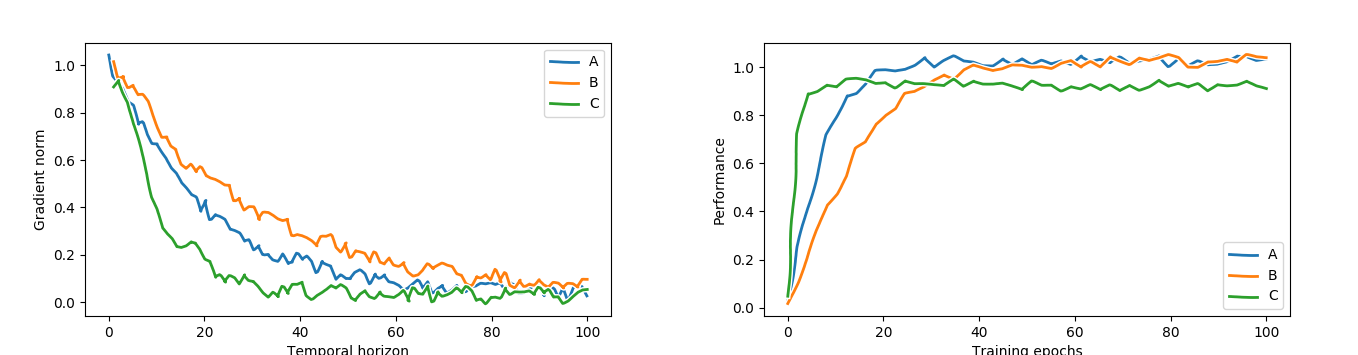

In [0]:
from IPython.display import Image, display
display(Image(filename='question_figs.png', width=850))

* Your answers here.

c.  Write down five possible Connectionist Temporal Classification (CTC) paths (of no more than a length of eight) that correspond to the same label "LADDER". (10%)

* Your answer here.\
1. LAD$\Phi$DER
2. LLAADD$\Phi$DDEERR
3. LLAD$\Phi$DER
4. LAAD$\Phi$DEER
5. LAD$\Phi$DDER